# Post-Processing Psuedo Surge Runs

In [1]:
!tail -n 12 ../Synthetic/SaveData/pseduo_surge_test.dat.names

  1: Time step
  2: Iteration step
  3: Boundary condition
  4: Node index
  5: coordinate 1
  6: coordinate 2
  7: coordinate 3
  8: zs
  9: zbed
 10: velocity 1
 11: velocity 2
 12: zs accumulation flux 2


In [2]:
import numpy as np 
from scipy import interpolate
import matplotlib.pyplot as plt 
from matplotlib import animation, rc

# rc('animation', html='jshtml')

plt.rcParams['text.usetex'] = True
plt.rcParams['animation.html'] = 'jshtml'

def vm(vx, vy):
    """Calculate vel. magnitude from x and y component"""
    return np.sqrt(vx**2 + vy**2)

#####################################################################################
# load model run and do some conversions
#####################################################################################
# Load and reshape to right size, and only use surface boundary values
NS_dat = np.loadtxt('../Synthetic/SaveData/pseduo_surge_test.dat').reshape(-1, 101,12)[::2,:,:]

# We don't really need much along the basal boundary condition, just vecolity and slip coeff: 
# Lets get the basal velocity, 
vx_b = np.loadtxt('../Synthetic/SaveData/pseduo_surge_test.dat').reshape(-1, 101,12)[1::2,:,9]
vy_b = np.loadtxt('../Synthetic/SaveData/pseduo_surge_test.dat').reshape(-1, 101,12)[1::2,:,10]

# Get magnitude of sliding velocity
v_b  = vm(vx_b,vy_b)

# flip all axes so x-coord is ascending not descending
#NS_dat = NS_dat[:,::-1,:]

# Anywhere where icethickness is less than 10 set z_s to z_b
NS_dat[:,:,7][~((NS_dat[:,:,7] - NS_dat[:,:,8]) > 10.)] = NS_dat[:,:,8][~((NS_dat[:,:,7] - NS_dat[:,:,8]) > 10.)]

# timestep vector (a)
t = NS_dat[:,0,0]/10

# X-coord (m)
x = NS_dat[0,:,4]

#####################################################################################
# load inital conidtions used in model run 
#####################################################################################
z_0 = np.loadtxt('../Synthetic/SaveData/LK_PRE_ST_full/lk_pre_500a_mb_2.6_off.dat').reshape(-1,101,12)[-1,:,7]

In [3]:
# Make space time grid for pcolormesh
XX, TT = np.meshgrid(x,t)

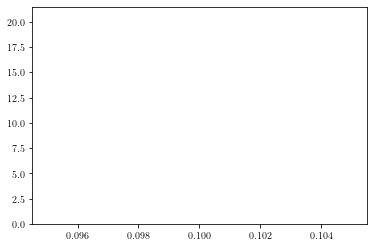

In [4]:
plt.pcolormesh(TT,XX/1000.,NS_dat[:,:,5] ,shading='gouraud')

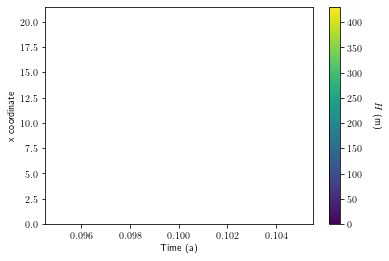

In [5]:
fig, ax = plt.subplots(1,1)
im = ax.pcolormesh(TT,XX/1000.,(NS_dat[:,:,7] - NS_dat[:,:,8]),shading='gouraud')

ax.set_ylabel('x coordinate')
ax.set_xlabel('Time (a)')

cbar = fig.colorbar(im)
cbar.set_label('$H$ (m)',rotation=270,labelpad=20)

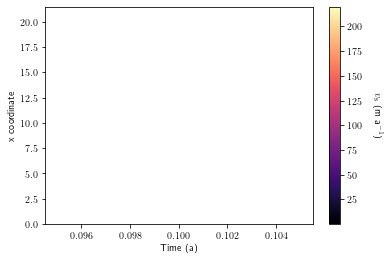

In [6]:
vm(NS_dat[:,:,9],NS_dat[:,:,10])

fig, ax = plt.subplots(1,1)

im = ax.pcolormesh(TT,
                   XX/1000.,
                   vm(NS_dat[:,:,9],NS_dat[:,:,10]),
                   cmap='magma',
                   shading='gouraud')


ax.set_ylabel('x coordinate')
ax.set_xlabel('Time (a)')

cbar = fig.colorbar(im)
cbar.set_label(r'$v_{\rm s}$ (m a$^{-1}$)',rotation=270,labelpad=20)

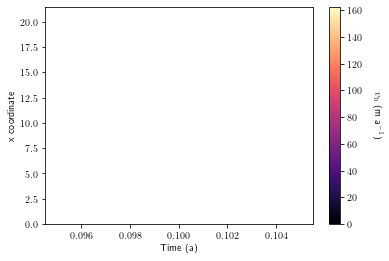

In [7]:
fig, ax = plt.subplots(1,1)

im = ax.pcolormesh(TT,
                   XX/1000.,
                   v_b,
                   cmap='magma',
                   shading='gouraud')

ax.set_ylabel('x coordinate')
ax.set_xlabel('Time (a)')

cbar = fig.colorbar(im)
cbar.set_label(r'$v_{\rm b}$ (m a$^{-1}$)',rotation=270,labelpad=20)

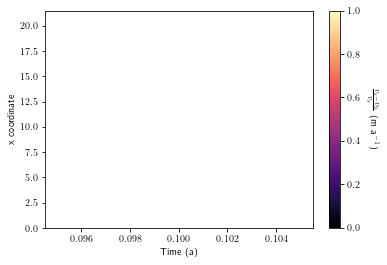

In [8]:
fig, ax = plt.subplots(1,1)

im = ax.pcolormesh(TT,
                   XX/1000.,
                   (vm(NS_dat[:,:,9],NS_dat[:,:,10])- v_b)/vm(NS_dat[:,:,9],NS_dat[:,:,10]),
                   cmap='magma',
                   shading='gouraud')

ax.set_ylabel('x coordinate')
ax.set_xlabel('Time (a)')

cbar = fig.colorbar(im)
cbar.set_label(r'$\frac{v_{\rm s} - v_{\rm b}}{v_{\rm s}}$ (m a$^{-1}$)',rotation=270,labelpad=20)

# A nice animation: 

In [9]:
fig, ax = plt.subplots(1,1,figsize=(6,3))

ax.set_xlim(NS_dat[0,:,4].min(),NS_dat[0,:,4].max())
ax.set_ylim(NS_dat[0,:,8].min()-25, NS_dat[0,:,8].max()+200)
ax.set_ylabel('m a.s.l.')
ax.set_xlabel('x-coord (m)')

ax.plot(x,NS_dat[0,:,8],color='saddlebrown')
ax.fill_between(x, np.ones(x.shape[0])*ax.get_ylim()[0], NS_dat[0,:,8], color='saddlebrown', alpha=0.5)

collection = ax.fill_between(x, z_0, NS_dat[0,:,8], color='lightblue', alpha=0.5)

ax.plot(x, z_0, 'k:', alpha=0.5, label='$z_s(t=0.0)$')
ax.legend()

line1, = ax.plot([], [], lw=2, color='lightblue', label='$z_s(t=0.0)$',)
line   = [line1]

def animate(i):
    if i == 0:
        ax.collections.clear()
        line[0].set_data(NS_dat[0,:,4], z_0)
        line[0].set_label('$z_s(t={{{:.1f}}})$'.format(i/10))

        ax.fill_between(x, np.ones(x.shape[0])*ax.get_ylim()[0], NS_dat[0,:,8], color='saddlebrown', alpha=0.5)
        ax.fill_between(x, z_0, NS_dat[0,:,8], color='lightblue', alpha=0.5)
        ax.legend()
    else:
        ax.collections.clear()
        line[0].set_label('$z_s(t={{{:.1f}}})$'.format(i/10))
        line[0].set_data(NS_dat[0,:,4], NS_dat[i-1,:,7])
        ax.fill_between(x, np.ones(x.shape[0])*ax.get_ylim()[0], NS_dat[0,:,8], color='saddlebrown', alpha=0.5)
        ax.fill_between(x, NS_dat[i-1,:,7], NS_dat[0,:,8], color='lightblue', alpha=0.5)
    
        ax.legend()

    return line

anim = animation.FuncAnimation(fig, animate, 
                               frames=range(0,NS_dat.shape[0]+1), interval=100, blit=True)

plt.tight_layout()
plt.close()
anim

In [79]:
anim.save('../plots/animation.mp4', fps=10, dpi=600)

# VTU files:

In [10]:
import os
import meshio
import xarray as xr

In [11]:
# Find the files matching out run/step name
fn_list = [os.path.join('../Synthetic/',fn) for fn in os.listdir('../Synthetic/') if 'pseduo_surge_test' in fn]
# Sort the file list based on the timestep
fn_list.sort(key=lambda i: int(i.split('_')[-1].split('.')[0][1:]))

In [36]:
tempdataset = xr.Dataset(data_vars = test_dict, 
                         coords    = {'yvals' : (('ynode','xnode'),ydim),
                          'xvals' : (('ynode','xnode'),xdim)} 
                        )

In [33]:
test_dict = {}
for key in mesh.point_data.keys():
    
    if key == 'mesh update':
        continue
        
    new_key = '_'.join(key.split(' '))

    if np.shape(mesh.point_data[key])[1] == 3: 
        test_dict[new_key+'_x'] = (('ynode','xnode'), mesh.point_data[key][:,0].reshape(ygrid_pts,xgrid_pts))
        test_dict[new_key+'_y'] = (('ynode','xnode'), mesh.point_data[key][:,1].reshape(ygrid_pts,xgrid_pts))
        test_dict[new_key+'_m'] = (('ynode','xnode'), 
                               vm(mesh.point_data[key][:,0].reshape(ygrid_pts,xgrid_pts), 
                                   mesh.point_data[key][:,1].reshape(ygrid_pts,xgrid_pts)))
    else:
        test_dict[new_key] = (('ynode','xnode'), mesh.point_data[key][:,0].reshape(ygrid_pts,xgrid_pts))
    
#     print( np.shape(mesh.point_data[key]))
#     # replace space in names with underscores
#     print('_'.join(key.split(' ')))

(1111, 1)
depth
(1111, 1)
pressure
(1111, 1)
zs
(1111, 1)
zs_residual
(1111, 1)
refzs
(1111, 1)
zs_accumulation_flux_2
(1111, 1)
zbed
(1111, 3)
velocity
(1111, 3)
mesh_velocity


In [12]:

#def vtu_read(fn_list, NX, NY):


#info about mesh grid (set by user in model - Mesh/mesh.grd )
xgrid_cells = 100
ygrid_cells = 10


xgrid_pts   = xgrid_cells + 1
ygrid_pts   = ygrid_cells + 1

xnodes      = np.array(range(xgrid_pts))      # ynodes 
ynodes      = np.array(range(ygrid_pts))      # xnodes
tsteps      = np.array(range(len(fn_list)))   # number of time steps

timestep = [] #list of data arrays
for path in fn_list:
    t_val = fn_list.index(path)
    print(path)
    mesh = meshio.read(path, file_format= 'vtu') #mesh the file

    velx = mesh.point_data['velocity'][:,0].reshape((ygrid_pts,xgrid_pts)) #reshape the mesh coordinates
    vely = mesh.point_data['velocity'][:,1].reshape((ygrid_pts,xgrid_pts))
    velm = vm(velx,vely)
    
    xdim = mesh.points[:,0].reshape((ygrid_pts,xgrid_pts))
    ydim = mesh.points[:,1].reshape((ygrid_pts,xgrid_pts))

    tempdataset = xr.Dataset(data_vars = {'vel_x' : (('ynode','xnode'), velx) ,
                                          'vel_y' : (('ynode','xnode'), vely) ,
                                          'vel_m' : (('ynode','xnode'), velm)},
                             coords    = {'yvals' : (('ynode','xnode'),ydim),
                                          'xvals' : (('ynode','xnode'),xdim)})
    timestep.append(tempdataset)

datacomb = xr.concat(timestep, dim='t')

../Synthetic/pseduo_surge_test_t0001.vtu
../Synthetic/pseduo_surge_test_t0002.vtu
../Synthetic/pseduo_surge_test_t0003.vtu
../Synthetic/pseduo_surge_test_t0004.vtu
../Synthetic/pseduo_surge_test_t0005.vtu
../Synthetic/pseduo_surge_test_t0006.vtu
../Synthetic/pseduo_surge_test_t0007.vtu
../Synthetic/pseduo_surge_test_t0008.vtu
../Synthetic/pseduo_surge_test_t0009.vtu
../Synthetic/pseduo_surge_test_t0010.vtu
../Synthetic/pseduo_surge_test_t0011.vtu
../Synthetic/pseduo_surge_test_t0012.vtu
../Synthetic/pseduo_surge_test_t0013.vtu
../Synthetic/pseduo_surge_test_t0014.vtu
../Synthetic/pseduo_surge_test_t0015.vtu
../Synthetic/pseduo_surge_test_t0016.vtu
../Synthetic/pseduo_surge_test_t0017.vtu
../Synthetic/pseduo_surge_test_t0018.vtu
../Synthetic/pseduo_surge_test_t0019.vtu
../Synthetic/pseduo_surge_test_t0020.vtu
../Synthetic/pseduo_surge_test_t0021.vtu
../Synthetic/pseduo_surge_test_t0022.vtu
../Synthetic/pseduo_surge_test_t0023.vtu
../Synthetic/pseduo_surge_test_t0024.vtu
../Synthetic/pse

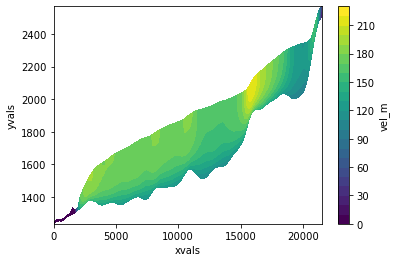

In [53]:
plt.rcParams['text.usetex'] = False

datacomb.sel(t=0).vel_m.plot.contourf(x = 'xvals', y = 'yvals', levels=25)

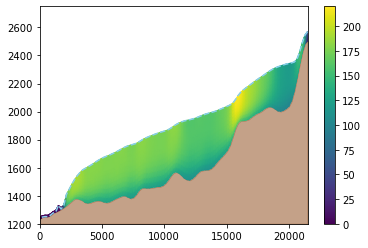

In [73]:

plt.ylim(1200,2750)
plt.fill_between(x, np.ones(x.shape[0])*plt.ylim()[0], NS_dat[0,:,8], color='saddlebrown',alpha=0.5)

plt.pcolormesh(datacomb.sel(t=0).xvals,
               datacomb.sel(t=0).yvals, 
               datacomb.sel(t=0).vel_m,
               shading='gouraud')

plt.plot(x,NS_dat[0,:,7],ls='--',color='skyblue')
#plt.plot(x,NS_dat[0,:,8],ls='--',color='saddlebrown')


plt.colorbar()
plt.savefig('/Users/andrewnolan/Desktop/test.png',dpi=600,bbox_inches='tight')

In [90]:
fig, ax = plt.subplots(1,1,figsize=(6,3))

ax.set_xlim(NS_dat[0,:,4].min(),NS_dat[0,:,4].max())
ax.set_ylim(NS_dat[0,:,8].min()-25, NS_dat[0,:,8].max()+200)
ax.set_ylabel('m a.s.l.')
ax.set_xlabel('x-coord (m)')

ax.plot(x,NS_dat[0,:,8],color='saddlebrown')
ax.fill_between(x, np.ones(x.shape[0])*ax.get_ylim()[0], NS_dat[0,:,8], color='saddlebrown', alpha=0.5)

ims = []
for t in np.arange(0,100): 
    im = ax.pcolormesh(datacomb.sel(t=t).xvals, 
                       datacomb.sel(t=t).yvals, 
                       datacomb.sel(t=t).vel_m, 
                       clim = (0, 200),
                       shading='gouraud')
    ims.append([im])

fig.colorbar(im, ax=ax)

#ims = [[im] for im in ims]
anim = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.tight_layout()
plt.close()
anim

In [94]:
datacomb.to_netcdf("/Users/andrewnolan/Desktop/test_xarray.nc")